In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [2]:
model_id = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'

In [3]:
sbc_files = [f for f in os.listdir(input_dir) if (f.startswith(model_id) and f.endswith('MN.pt'))]
sbc_files.sort()
print(sbc_files)

counts = np.unique(np.array([int(f.split("_")[-2]) for f in sbc_files]))
print("counts", counts)

['ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_0_MN.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_1_MN.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_2_MN.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_3_MN.pt', 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_4_MN.pt']
counts [0 1 2 3 4]


In [4]:
# Load files
phi_truth_all = None
phi_samples_all = None
max_num_samples = 240
for sbc_file in sbc_files:
    print(sbc_file)
    sbc_file = os.path.join(input_dir, sbc_file)
    sbc_data = torch.load(sbc_file)
    phi_truth = sbc_data["rphi_true"].detach().cpu()
    phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
    if phi_truth_all is None:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = phi_truth
        phi_samples_all = phi_samples[:max_num_samples, :, :]
    else:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = torch.cat((phi_truth_all, phi_truth), dim=0)
        phi_samples_all = torch.cat((phi_samples_all, phi_samples[:max_num_samples, :, :]), dim=1)
try:
    print(phi_truth_all.shape, phi_samples_all[:max_num_samples, :, :].shape)
except:
    print("No samples")

ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_0_MN.pt
ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_1_MN.pt


ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_2_MN.pt
ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_3_MN.pt
ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01_4_MN.pt
torch.Size([1280, 2]) torch.Size([240, 1280, 2])


In [5]:
nb_burning_samples = 20

# Get rid of the burnin samples
phi_samples_all = phi_samples_all[nb_burning_samples:, :, :]

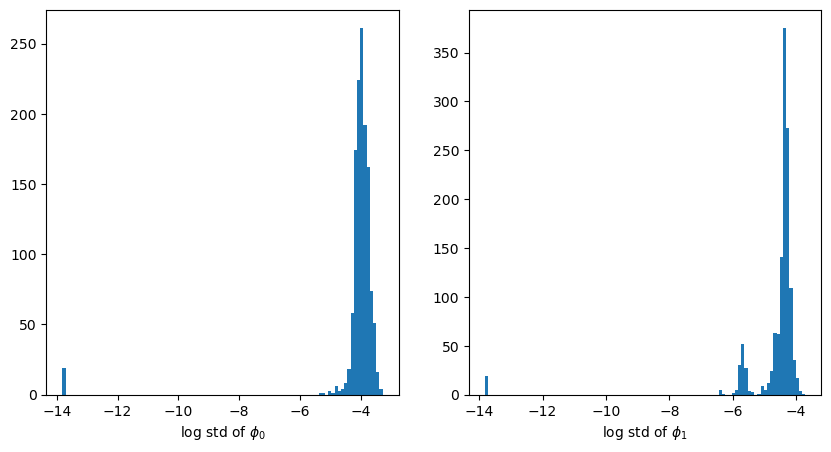

In [6]:
# Show histogram of stds
eps = 1e-6
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(torch.log(phi_samples_all[..., 0].std(dim=0) + eps), bins=100)
axs[0].set_xlabel("log std of $\phi_0$")
axs[1].hist(torch.log(phi_samples_all[..., 1].std(dim=0) + eps), bins=100)
axs[1].set_xlabel("log std of $\phi_1$")
plt.show()

In [7]:
# Remove chains that have not converged
# Add a condition about distance to the true value (if mean dist larger than 0.5, then remove)

threshold = -6
converged_indices = {}
not_converged_indices = {}
converged_indices = torch.where(torch.logical_and(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) >= threshold,torch.logical_and(
                                                torch.log(phi_samples_all[..., 1].std(dim=0) + eps) >= threshold, 
                                                torch.norm(phi_samples_all.mean(dim=0) - phi_truth_all, dim=1) <=0.5,)))[0]
not_converged_indices = torch.where(torch.logical_or(torch.logical_or(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) < threshold,
                                                    torch.log(phi_samples_all[..., 1].std(dim=0) + eps) < threshold), 
                                                    torch.norm(phi_samples_all.mean(dim=0) - phi_truth_all, dim=1) > 0.5))[0]
print("Number of chains that have not converged:", not_converged_indices.shape[0])

Number of chains that have not converged: 26


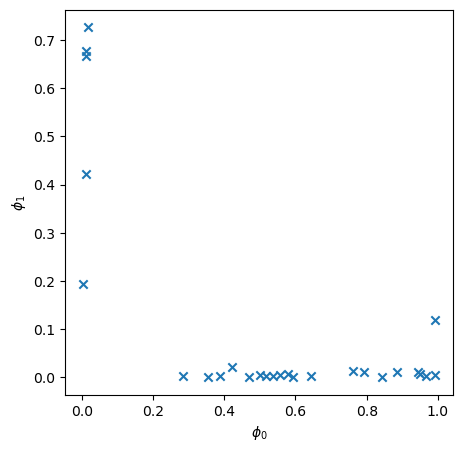

In [8]:
# Plot parameters for the chains that have not converged
plt.figure(figsize=(5, 5))
plt.scatter(phi_truth_all[not_converged_indices, 0],
            phi_truth_all[not_converged_indices, 1],
            marker='x')
plt.xlabel("$\phi_0$")
plt.ylabel("$\phi_1$")
plt.show()

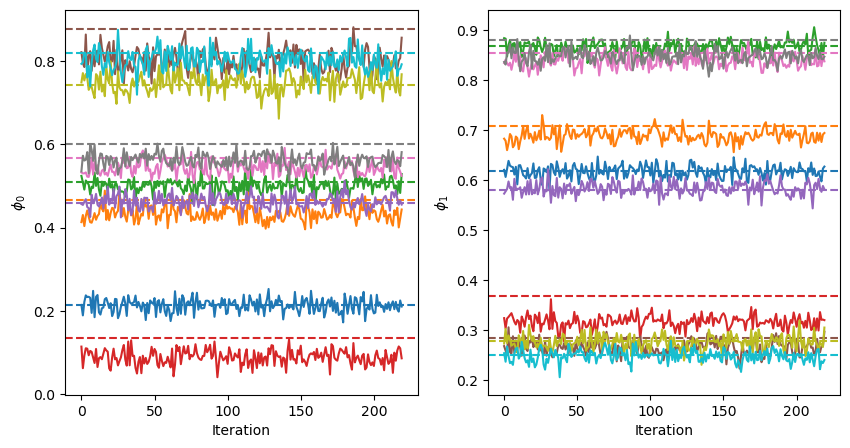

In [9]:
# Plot randomly selected chains
nb_plot_chains = 10

plot_indices = torch.randperm(phi_samples_all[:,converged_indices].shape[1])[:nb_plot_chains]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(nb_plot_chains):
    axs[0].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 0], color=f'C{i}')
    axs[0].axhline(phi_truth_all[converged_indices][plot_indices[i], 0], color=f'C{i}', linestyle='--')
    axs[1].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 1], color=f'C{i}')
    axs[1].axhline(phi_truth_all[converged_indices][plot_indices[i], 1], color=f'C{i}', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$\phi_0$")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$\phi_1$")
plt.show()

In [10]:
# Compute rank statistics
phi_truth_all_converged = phi_truth_all[converged_indices, :]
phi_samples_all_converged = phi_samples_all[:, converged_indices, :]
ranks = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
for i in range(phi_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
    for j in range(phi_truth_all_converged.shape[1]):
        autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
        ranks[i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [11]:
from scipy.stats import binom

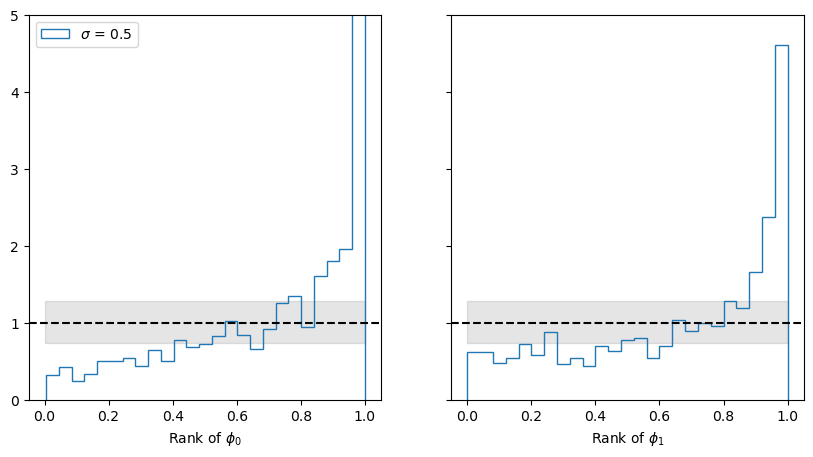

In [12]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axs[0].hist(ranks[:, 0], bins=25, density=True, histtype='step', label=f"$\sigma$ = 0.5")
axs[1].hist(ranks[:, 1], bins=25, density=True, histtype='step')
nbins = 25
N = ranks.shape[0]
q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[0].legend()
axs[0].set_ylim([0, 5])
plt.show()

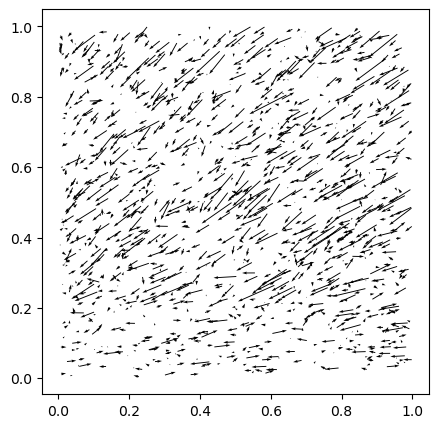

In [13]:
## Plot a vector field where each vector starts at the true value and ends at the mean of the chains
plt.figure(figsize=(5, 5))
plt.quiver(phi_truth_all_converged[:, 0], phi_truth_all_converged[:, 1], 
           phi_samples_all_converged.mean(dim=0)[:, 0] - phi_truth_all_converged[:, 0], 
           phi_samples_all_converged.mean(dim=0)[:, 1] - phi_truth_all_converged[:, 1], 
           scale=1, scale_units='xy', angles='xy')


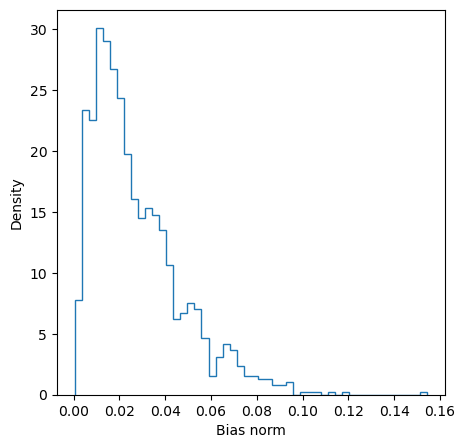

In [14]:
## Plot the distribution for the bias norm 

# Compute the bias norm
bias_norm = torch.norm(phi_samples_all_converged.mean(dim=0) - phi_truth_all_converged, dim=1)

# Plot the distribution
plt.figure(figsize=(5, 5))
plt.hist(bias_norm, bins=50, histtype='step', density=True)
plt.xlabel("Bias norm")
plt.ylabel("Density")
plt.show()